# Extract

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

db_raw=pd.read_csv('./data/kc_house_data.csv')

In [2]:
def analisar_visao_agua(df_base,col):
    df=df_base[[col,'price','waterfront']].groupby(['waterfront',col]).mean().reset_index()
    x=df[df['waterfront']==1][[col,'price']]
    x.columns=[col,'waterfront']
    y=df[df['waterfront']==0][[col,'price']]
    y.columns=[col,'no_waterfront']
    df=pd.merge(x,y,how='inner',on=[col])
    df['comp']=df[['waterfront','no_waterfront']].apply(lambda x: x['waterfront']/x['no_waterfront'],axis=1)
    return(df)

# Transform

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
db_total=db_raw.copy()
db_total.drop(columns=['sqft_living15','sqft_lot15'],inplace=True)
db_total['date']=pd.to_datetime(db_total['date'])
db=db_total.sort_values('date',ascending=False).drop_duplicates('id')

## Data Engeneering

In [4]:
db['living_comp']=db['sqft_living'].apply(lambda x:'0-1354' if x<1354 else
                                                    '1354-2708' if x<2708 else
                                                    '2708-4062' if x<4062 else
                                                    '4062-5416' if x<5416 else
                                                    '5416-6770' if x<6770 else
                                                    '6770-8124' if x<8124 else
                                                    '8124-9478' if x<9478 else
                                                    '9478-10832' if x<10832 else
                                                    '10832-12186' if x<12186 else
                                                    '12186-13540')
db['lot_comp']=db['sqft_lot'].apply(lambda x: '0-165136' if x<165136 else
                                            '165136-330272' if x<330272 else
                                            '330272-495408' if x<495408 else
                                            '495408-660544' if x<660544 else
                                            '660544-825680' if x<825680 else
                                            '825680-990816' if x<990816 else
                                            '990816-1155952' if x<1155952 else
                                            '1155952-1321088' if x<1321088 else
                                            '1321088-1486224' if x<1486224 else
                                            '1486224-1651359')
db['1955']=db['yr_built'].apply(lambda x: 'antes' if x<1995 else 'depois')
db['year_month']=db['date'].dt.strftime('%Y-%m')
db['basement']=db['sqft_basement'].apply(lambda x: 'yes' if x>0 else 'no')
db['month']=db['date'].apply(lambda x: x.month)
db['year']=db['date'].apply(lambda x: x.year)

In [5]:
db['price_lot']=db[['price','sqft_lot']].apply(lambda x: x['price']/x['sqft_lot'],axis=1)

#df1 -> Tabela de preço/tamanho mediano de cada zipcode e condition
df1=db[['zipcode','condition','price_lot']].groupby(['zipcode','condition']).median().reset_index().sort_values(['zipcode','condition'])
df1.columns=['zipcode','condition','zipcode_price_lot']


db=pd.merge(db,df1,on=['zipcode','condition'],how='left')
db['buy']=db[['price_lot','zipcode_price_lot']].apply(lambda x: 'yes' if x['price_lot']<x['zipcode_price_lot'] else 'no',axis=1)

#df2 -> Tabela de casas para comprar
df2=db[(db['buy']=='yes')].reset_index(drop=True)

# Loop de verificação para saber se vale a pena reformar a casa
for lin in range(len(df2)):         #loop de cada linha
    # Var
    nivel_condicao=0                                                                                                    #zerando variavel
    zipcode=df2.loc[lin,'zipcode']                                                                                      #zipcode da linha atual
    cond_lin=df2.loc[lin,'condition']                                                                                   #condição do imovel da linha atual
    preco_comp=df1.loc[(df1['zipcode']==zipcode)&(df1['condition']==cond_lin),'zipcode_price_lot'].values[0]            #valor do pé² comparativo
    list_conditions=df1[(df1['zipcode']==zipcode)&(df1['condition']>cond_lin)]['condition'].unique().tolist()           #lista de condições do zipcode da linha atual

    for cond in list_conditions:    #loop de verificação
        # Var
        preco_pes_zipcode=df1.loc[(df1['zipcode']==zipcode)&(df1['condition']==cond),'zipcode_price_lot'].values[0]     #preço/pes² da condição do imovel do zipcode

        if preco_comp<preco_pes_zipcode:
            preco_comp=preco_pes_zipcode
            nivel_condicao=cond

    if nivel_condicao==0:
        df2.loc[lin,'action']='sell'
    else:
        df2.loc[lin,'action']='renovate'
        df2.loc[lin,'renovate_to']=int(nivel_condicao)
    
df2.drop(columns=['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
                    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                    'lat', 'long','price_lot',
                    'zipcode_price_lot','buy','living_comp','lot_comp','1955','year_month',
                    'basement','month','year'],inplace=True)
db=pd.merge(db,df2,on=['id'],how='left')
db['action']=db['action'].fillna('dont_buy')

In [6]:
df2.columns

Index(['id', 'action', 'renovate_to'], dtype='object')

# Analysis

## Imóveis com vista para água, na média, são 20% mais caros!

R: Não, os imóveis com vista para a água são 212% (ou 2,12 vezes) mais caros  que os imóveis sem vista para a água.

In [7]:
a=db[['waterfront','price']].groupby('waterfront').mean().reset_index()
a.loc[1,'price']/a.loc[0,'price']

3.1175775413549207

In [8]:
analisar_visao_agua(db,'condition')


,condition,waterfront,no_waterfront,comp
0,1,658000.00,331051.79,1.99
1,2,2555000.00,319367.42,8.00
2,3,1759075.82,535773.50,3.28
3,4,1520318.00,513215.67,2.96
4,5,1579049.60,601538.74,2.63


In [9]:
analisar_visao_agua(db,'living_comp')

,living_comp,waterfront,no_waterfront,comp
0,0-1354,495885.71,334605.58,1.48
1,1354-2708,960340.04,476080.55,2.02
2,2708-4062,1704762.04,797878.11,2.14
3,4062-5416,2610207.69,1356589.82,1.92
4,5416-6770,3088928.57,1759257.66,1.76
5,6770-8124,4222200.00,2485714.17,1.70
6,9478-10832,5865250.00,6885000.00,0.85


In [10]:
analisar_visao_agua(db,'floors')

,floors,waterfront,no_waterfront,comp
0,1.00,1258935.09,439435.08,2.86
1,1.50,1364040.10,552925.74,2.47
2,2.00,2029408.67,636449.90,3.19
3,2.50,2789000.00,1038602.42,2.69
4,3.00,1587250.00,569113.54,2.79


In [11]:
analisar_visao_agua(db,'lot_comp')

,lot_comp,waterfront,no_waterfront,comp
0,0-165136,1672371.38,530884.81,3.15
1,165136-330272,635000.00,671922.51,0.95
2,495408-660544,999000.00,616433.33,1.62


## Imóveis com construção menor de 1955, são 50% mais baratos na média!

R: Não, as casa são, aproximadamente, 17% mais baratas em média.

In [12]:
db_t=db[['price','1955']].groupby('1955').mean().reset_index()
print(db_t)
print((1-(db_t.loc[0,'price']/db_t.loc[1,'price']))*100)

     1955     price
0   antes 513557.79
1  depois 617651.78
16.853183149629235


## Imóveis com porão são mais caros, em média, do que os sem porão!

Fazendo comparação das casas de cada nível em seus respectivos "zipcodes"

R: Sim, os imóveis com porão são, aproximadamente, 30% mais caros em média do que os sem porão


In [13]:
basement=db[db['basement']=='yes'][['zipcode','condition','price']].groupby(['zipcode','condition']).mean().reset_index()
basement.columns=['zipcode','condition','basement']
no_basement=db[db['basement']=='no'][['zipcode','condition','price']].groupby(['zipcode','condition']).mean().reset_index()
no_basement.columns=['zipcode','condition','no_basement']
db_t=pd.merge(no_basement,basement,how='inner',on=['zipcode','condition'])
db_t['comp']=db_t[['basement','no_basement']].apply(lambda x: x['basement']/x['no_basement'],axis=1)
print('Comp > 1: '+str(db_t[db_t['comp']>1].shape[0]))
print('Comp < 1: '+str(db_t[db_t['comp']<1].shape[0]))
print('Comp = 1: '+str(db_t[db_t['comp']==1].shape[0]))
print('Média "Comp > 1": '+str(db_t[db_t['comp']>1]['comp'].mean()))

Comp > 1: 190
Comp < 1: 34
Comp = 1: 0
Média "Comp > 1": 1.295452328115746


## Imóveis de 3 banheiros tem um crescimento de MoM de 15%

R:Não, os imóveis tem um movimento de preço de imóvel praticamente nulo

In [14]:
db_t=db[['price','year_month']].groupby('year_month').mean().reset_index(drop=True)
for i in range(len(db_t)):
    if i>0:
        db_t.loc[i,'comp']=(db_t.loc[i,'price']/db_t.loc[i-1,'price'])*100
db_t[db_t['comp'].notnull()]['comp'].mean()



100.17402619485057

## Imóveis reformados recentemente tem valor mais alto

R: Sim, tem uma tendencia de aumento de preço nas casas com reformas recentemente com o passar do tempo 

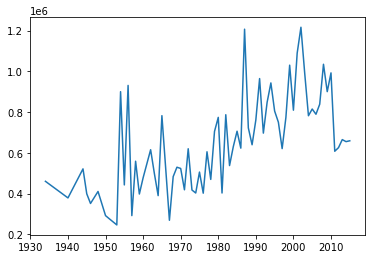

In [15]:
a=db[db['yr_renovated']!=0][['price','yr_renovated']].copy()
a=a.groupby('yr_renovated').mean().reset_index()
plt.plot(a['yr_renovated'],a['price']);

## Imóveis sem porão possuem área total 40% maiores do que os imóveis com porão

R: Não, imóveis sem porão são, aproximadamente, 23% maiores

In [16]:
db_t=db[['basement','sqft_lot']].groupby('basement').mean().reset_index()
db_t.loc[0,'sqft_lot']/db_t.loc[1,'sqft_lot']

1.227883234194123

## O crescimento do preço dos imóves YoY é de 10%

R: Não. No geral, o crescimento YoY é de 2%, porém, para as casas em condição 5 tem um YoY de 18%

In [17]:
m2014=db[db['year_month']=='2014-05'][['price','year_month','condition']].groupby(['year_month','condition']).mean().reset_index().drop(columns='year_month')
m2014.columns=[['condition','m2014']]
m2015=db[db['year_month']=='2015-05'][['price','year_month','condition']].groupby(['year_month','condition']).mean().reset_index().drop(columns='year_month')
m2015.columns=[['condition','m2015']]
db_t=m2014.merge(m2015,how='inner')
db_t['growth_rate']=db_t[['m2014','m2015']].apply(lambda x: (x['m2015']-x['m2014'])/x['m2014'],axis=1)
print(db_t['growth_rate'].mean())
db_t


#a=pd.merge(m2014,m2015,how='left',on='condition')
#plt.bar(db['year_month'],db['price'])

growth_rate   0.02
dtype: float64


,condition,m2014,m2015,growth_rate
0,1,294333.33,295000.00,0.00
1,2,413164.00,387800.00,-0.06
2,3,551186.72,575695.19,0.04
3,4,522442.24,497371.88,-0.05
4,5,635853.65,751298.30,0.18


# Graphics

In [18]:
db1=db[['bedrooms','price']].groupby('bedrooms').count().reset_index()
fig2=px.bar(db1,x='bedrooms',y='price')
fig2

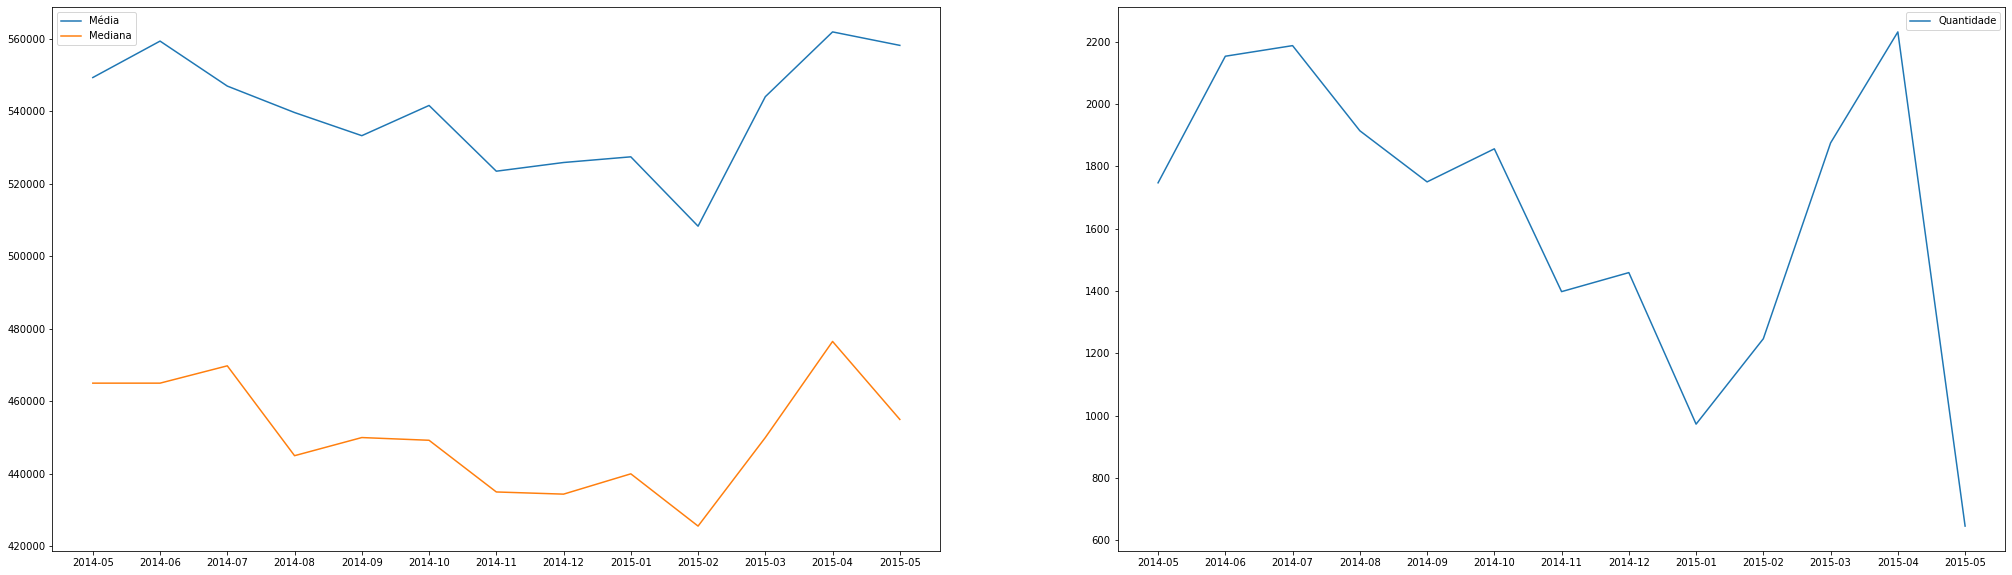

In [19]:
df1=db[['price','year_month']].groupby('year_month').count().reset_index()
df2=db[['price','year_month']].groupby('year_month').mean().reset_index()
df3=db[['price','year_month']].groupby('year_month').median().reset_index()

plt.figure(figsize=(35,10))

plt.subplot(1,2,1)
plt.plot(df2['year_month'],df2['price'],label='Média')
plt.plot(df3['year_month'],df3['price'],label='Mediana')
plt.legend()
plt.subplot(1,2,2)
plt.plot(df1['year_month'],df1['price'],label='Quantidade')
plt.legend()

# Entregas

## Tabela de imóveis para não comprar

In [20]:
tab1=db[db['buy']=='no'].drop(columns=['action','renovate_to'])
tab1

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,living_comp,lot_comp,1955,year_month,basement,month,year,price_lot,zipcode_price_lot,buy
0,9106000005,2015-05-27,1310000.00,4,2.25,3750,5000,2.00,0,0,...,2708-4062,0-165136,antes,2015-05,yes,5,2015,262.00,135.52,no
3,8730000270,2015-05-14,359000.00,2,2.75,1370,1140,2.00,0,0,...,1354-2708,0-165136,depois,2015-05,yes,5,2015,314.91,61.40,no
4,9178601660,2015-05-14,1695000.00,5,3.00,3320,5354,2.00,0,0,...,2708-4062,0-165136,depois,2015-05,no,5,2015,316.59,224.58,no
8,8149600265,2015-05-14,725000.00,4,1.75,1980,5850,1.00,0,1,...,1354-2708,0-165136,antes,2015-05,yes,5,2015,123.93,108.70,no
9,8562790720,2015-05-14,749950.00,4,3.50,2630,3757,2.00,0,0,...,1354-2708,0-165136,depois,2015-05,yes,5,2015,199.61,100.78,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21424,2738600140,2014-05-02,499950.00,4,2.50,2860,3345,2.00,0,0,...,2708-4062,0-165136,depois,2014-05,yes,5,2014,149.46,28.61,no
21426,1771000430,2014-05-02,315000.00,3,1.00,1160,9180,1.00,0,0,...,0-1354,0-165136,antes,2014-05,no,5,2014,34.31,17.70,no
21428,3390600010,2014-05-02,365000.00,3,1.00,1090,6435,1.00,0,0,...,0-1354,0-165136,antes,2014-05,no,5,2014,56.72,54.55,no
21430,9294300070,2014-05-02,650000.00,4,2.00,1820,5000,1.50,0,1,...,1354-2708,0-165136,antes,2014-05,yes,5,2014,130.00,107.74,no


## Tabela de imóveis para comprar e vender

In [21]:
tab2=db[db['action']=='sell']
tab2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,1955,year_month,basement,month,year,price_lot,zipcode_price_lot,buy,action,renovate_to
2,7923600250,2015-05-15,450000.00,5,2.00,1870,7344,1.50,0,0,...,antes,2015-05,no,5,2015,61.27,65.72,yes,sell,NaN
5,6815100380,2015-05-14,855000.00,3,1.75,1900,4000,1.00,0,0,...,antes,2015-05,yes,5,2015,213.75,224.58,yes,sell,NaN
6,1786200010,2015-05-14,456500.00,4,2.50,2580,11780,2.00,0,0,...,depois,2015-05,no,5,2015,38.75,57.92,yes,sell,NaN
11,1422700040,2015-05-14,183000.00,3,1.00,1170,7320,1.00,0,0,...,antes,2015-05,no,5,2015,25.00,30.72,yes,sell,NaN
24,9542801310,2015-05-13,267000.00,3,2.25,2510,9900,1.00,0,0,...,antes,2015-05,yes,5,2015,26.97,33.08,yes,sell,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21420,2326059099,2014-05-02,838000.00,4,2.50,3310,42998,2.00,0,0,...,depois,2014-05,no,5,2014,19.49,74.84,yes,sell,NaN
21427,1245003160,2014-05-02,698000.00,4,2.25,2200,11250,1.50,0,0,...,antes,2014-05,yes,5,2014,62.04,63.82,yes,sell,NaN
21429,7853220390,2014-05-02,785000.00,5,3.25,3660,11995,2.00,0,2,...,depois,2014-05,no,5,2014,65.44,89.05,yes,sell,NaN
21433,587550340,2014-05-02,604000.00,3,2.50,3240,33151,2.00,0,2,...,depois,2014-05,no,5,2014,18.22,33.08,yes,sell,NaN


## Tabela de imóveis para comprar, reformar e vender

In [22]:
tab3=db[db['action']=='renovate']
tab3

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,1955,year_month,basement,month,year,price_lot,zipcode_price_lot,buy,action,renovate_to
1,5101400871,2015-05-24,445500.00,2,1.75,1390,6670,1.00,0,0,...,antes,2015-05,yes,5,2015,66.79,107.74,yes,renovate,5.00
7,4166600610,2015-05-14,335000.00,3,2.00,1410,44866,1.00,0,0,...,antes,2015-05,no,5,2015,7.47,28.60,yes,renovate,5.00
22,3649100015,2015-05-13,480000.00,3,2.25,1820,15000,1.00,0,0,...,antes,2015-05,yes,5,2015,32.00,46.19,yes,renovate,5.00
27,3025300250,2015-05-13,1620000.00,4,2.25,2350,17709,2.00,0,0,...,antes,2015-05,no,5,2015,91.48,104.21,yes,renovate,5.00
33,8731730590,2015-05-13,242150.00,4,1.75,1490,8544,1.00,0,0,...,antes,2015-05,no,5,2015,28.34,32.52,yes,renovate,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21416,3876200060,2014-05-02,382500.00,4,1.75,1560,8700,1.00,0,0,...,antes,2014-05,no,5,2014,43.97,54.55,yes,renovate,5.00
21421,2618300080,2014-05-02,242500.00,3,1.50,1200,9720,1.00,0,0,...,antes,2014-05,no,5,2014,24.95,25.96,yes,renovate,5.00
21425,7197300105,2014-05-02,550000.00,4,2.50,1940,10500,1.00,0,0,...,antes,2014-05,yes,5,2014,52.38,59.93,yes,renovate,5.00
21432,2202500290,2014-05-02,435000.00,4,1.00,1450,8800,1.00,0,0,...,antes,2014-05,no,5,2014,49.43,62.28,yes,renovate,5.00


## Mapa com imóveis

In [23]:
mapa=db[['id', 'date', 'price', 'sqft_lot', 'condition', 'zipcode', 'lat', 'long', 'action', 'renovate_to']]
fig=px.scatter_mapbox(mapa,
                        lat='lat',
                        lon='long',
                        color='action',
                        size='price',
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=30,
                        zoom=10)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600,margin={'r':0,'t':0,'l':0,'b':0})

# "Load"

In [24]:
db.drop(columns=['living_comp', 'lot_comp', '1955','view', 'grade','year_month']).to_csv('data/final_data.csv',sep=';',index=False)